# Importação das dependências

In [1]:
import os
import tensorflow as tf

tf.config.run_functions_eagerly(True)

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2 
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# Carregando modelo

In [2]:
modelName = "ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8"
modelConfigurationsPath = os.path.join("models", modelName, "pipeline.config")

modelConfigurations = config_util.get_configs_from_pipeline_file(modelConfigurationsPath)

model = model_builder.build(model_config=modelConfigurations['model'], is_training=False)

# Carregando checkpoint do modelo

In [3]:
# Carregando checkpoint do modelo
modelCheckpoint = tf.compat.v2.train.Checkpoint(model=model)

modelCheckpoint.restore(os.path.join("models", modelName, 'ckpt-2')).expect_partial()

# Definindo função de detecção

In [4]:
# Definindo função de detecção
@tf.function
def detect_fn(image):
    image, shapes = model.preprocess(image)
    
    prediction_dict = model.predict(image, shapes)
    
    detections = model.postprocess(prediction_dict, shapes)
    
    return detections

# Realizando leitura da imagem a ser analisada

In [5]:
imagePath = os.path.join("dataset", 'test', '0de5d265-1476-4012-8743-19496b416365_1.jpg')

image = cv2.imread(imagePath)

imageArray = np.array(image)

imageTensor = tf.convert_to_tensor(np.expand_dims(imageArray, 0), dtype=tf.float32)

# Realizando detecções

In [6]:
detections = detect_fn(imageTensor)

num_detections = int(detections.pop('num_detections'))

detections = {
    key: value[0, :num_detections].numpy()
        for key, value in detections.items()
}

detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# Exibindo detecções

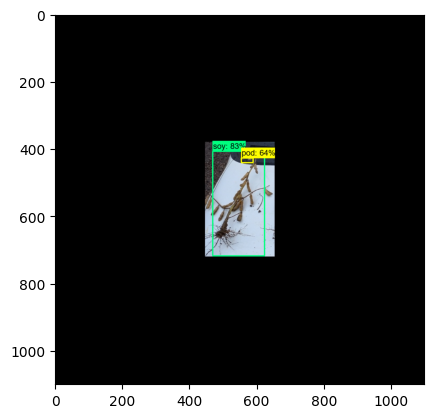

In [7]:
label_id_offset = 1

image_np_with_detections = imageArray.copy()

category_index = label_map_util.create_category_index_from_labelmap('label_map.pbtxt')

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.6,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()
